In [1]:
#import modules in cells 1 through 4

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
# Python and SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# Create engine to read the SQL file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

In [7]:
# View classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
#identify datatypes in measurement

inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create session from Python to the DB
session = Session(engine)

In [11]:
# Display the row's columns and data in dictionary form
first_row_measurement = session.query(Measurement).first()
first_row_measurement.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1213490f0>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'station': 'USC00519397',
 'prcp': 0.08,
 'id': 1}

In [63]:
#write a script to identify the last year's worth of data; save the data to individual lists
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()


('2017-08-23')

In [71]:
#write a query to find one year prior to the last_date

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

print(query_date)
 

2016-08-23


In [14]:
#iterate through the data; store into lists

last_year_data = (session.query(Measurement.date, Measurement.prcp)
                  .filter(Measurement.date > str(query_date))
                  .order_by(Measurement.date).all())

measurement_date = []
measurement_prcp = []


for row in last_year_data:
    measurement_date.append(row[0])
    measurement_prcp.append(row[1])
    
combined_data = list(zip(measurement_date, measurement_prcp))


In [15]:
#create a pandas dataframe to store the information; clean the data

combined_data_df = pd.DataFrame(combined_data, columns=('date', 'precipitation'))

cleaned_df = combined_data_df.dropna()

indexed_df = cleaned_df.set_index('date')

indexed_df.head()

,precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


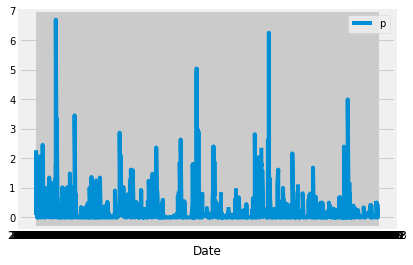

In [16]:
#plot the data from the dataframe
import matplotlib.dates as mdates


plt.plot(measurement_date, measurement_prcp)
plt.legend('precipitation')
plt.xlabel('Date')

plt.show()

In [17]:
#design a query to calculate the total number of stations
#first step is to figure out what the data looks like, and how the data is formatted

#identify datatypes in station

inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [18]:
# Display the station row's columns and data in dictionary form
first_row_station = session.query(Station).first()
first_row_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x121ba7b38>,
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

In [19]:
#count the total number of stations

station_entries = (session.query(
                    func.count(Station.name))
                  .all())
                                
print(f"There are {station_entries[0]} stations in the Station dataset.")

There are (9,) stations in the Station dataset.


In [20]:
#create a query to find the most active stations
#use functions such as min, max, count, and average as needed

station_count = (session.query(Station.name,
                               Measurement.station,
                              func.count(Measurement.tobs))
                .filter(Station.station == Measurement.station)
                .group_by(Station.name)
                .order_by(func.count(Measurement.tobs).desc())
                .all()
                )

station_count_df = pd.DataFrame(station_count, columns=('Name', 'Station', 'Total Observations'))

station_count_df

,Name,Station,Total Observations
0,"WAIHEE 837.5, HI US",USC00519281,2772
1,"WAIKIKI 717.2, HI US",USC00519397,2724
2,"KANEOHE 838.1, HI US",USC00513117,2709
3,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,2669
4,"MANOA LYON ARBO 785.2, HI US",USC00516128,2612
5,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,2202
6,"HONOLULU OBSERVATORY 702.2, HI US",USC00511918,1979
7,"PEARL CITY, HI US",USC00517948,1372
8,"UPPER WAHIAWA 874.3, HI US",USC00518838,511


In [21]:
#use similar query to above to identify the station w/ highest observation count;
#save the results into a variable to be used below

station_leader = station_count = (session.query(Station.name,
                               Measurement.station,
                              func.count(Measurement.tobs))
                .filter(Station.station == Measurement.station)
                .group_by(Station.name)
                .order_by(func.count(Measurement.tobs).desc())
                .first())

station_leader[1]

'USC00519281'

In [22]:
# Display the row's columns and data in dictionary form
first_row_measurement = session.query(Measurement).first()
first_row_measurement.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1213490f0>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'station': 'USC00519397',
 'prcp': 0.08,
 'id': 1}

In [23]:
#Design a query to retrieve the last 12 months of temperature observation data (tobs)
#Data must come from the station with the highest observation count

annual_data = (session.query(Measurement.tobs)
                  .filter(Station.station == Measurement.station)
                .filter(Measurement.date > str(query_date))
                .filter(Measurement.station == str(station_leader[1]))
                .all())

annual_data

[(77.0),
 (80.0),
 (80.0),
 (75.0),
 (73.0),
 (78.0),
 (77.0),
 (78.0),
 (80.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (73.0),
 (74.0),
 (80.0),
 (79.0),
 (77.0),
 (80.0),
 (76.0),
 (79.0),
 (75.0),
 (79.0),
 (78.0),
 (79.0),
 (78.0),
 (78.0),
 (76.0),
 (74.0),
 (77.0),
 (78.0),
 (79.0),
 (79.0),
 (77.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (75.0),
 (76.0),
 (73.0),
 (72.0),
 (71.0),
 (77.0),
 (79.0),
 (78.0),
 (79.0),
 (77.0),
 (79.0),
 (77.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (74.0),
 (75.0),
 (76.0),
 (73.0),
 (76.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (74.0),
 (75.0),
 (75.0),
 (75.0),
 (75.0),
 (71.0),
 (63.0),
 (70.0),
 (68.0),
 (67.0),
 (77.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (75.0),
 (76.0),
 (75.0),
 (73.0),
 (75.0),
 (73.0),
 (75.0),
 (74.0),
 (75.0),
 (74.0),
 (75.0),
 (73.0),
 (75.0),
 (73.0),
 (73.0),
 (74.0),
 (70.0),
 (72.0),
 (70.0),
 (67.0),
 (67.0),
 (69.0),
 (70.0),
 (68.0),
 (69.0),
 (69.0),
 (66.0),
 

In [24]:
#put data into list so i can plot it

list_annual_data = []

for row in annual_data:
    list_annual_data.append(row[0])
    
print(list_annual_data)

[77.0, 80.0, 80.0, 75.0, 73.0, 78.0, 77.0, 78.0, 80.0, 80.0, 78.0, 78.0, 78.0, 73.0, 74.0, 80.0, 79.0, 77.0, 80.0, 76.0, 79.0, 75.0, 79.0, 78.0, 79.0, 78.0, 78.0, 76.0, 74.0, 77.0, 78.0, 79.0, 79.0, 77.0, 80.0, 78.0, 78.0, 78.0, 77.0, 79.0, 79.0, 79.0, 79.0, 75.0, 76.0, 73.0, 72.0, 71.0, 77.0, 79.0, 78.0, 79.0, 77.0, 79.0, 77.0, 78.0, 78.0, 78.0, 78.0, 77.0, 74.0, 75.0, 76.0, 73.0, 76.0, 74.0, 77.0, 76.0, 76.0, 74.0, 75.0, 75.0, 75.0, 75.0, 71.0, 63.0, 70.0, 68.0, 67.0, 77.0, 74.0, 77.0, 76.0, 76.0, 75.0, 76.0, 75.0, 73.0, 75.0, 73.0, 75.0, 74.0, 75.0, 74.0, 75.0, 73.0, 75.0, 73.0, 73.0, 74.0, 70.0, 72.0, 70.0, 67.0, 67.0, 69.0, 70.0, 68.0, 69.0, 69.0, 66.0, 65.0, 68.0, 62.0, 75.0, 70.0, 69.0, 76.0, 76.0, 74.0, 73.0, 71.0, 74.0, 74.0, 72.0, 71.0, 72.0, 74.0, 69.0, 67.0, 72.0, 70.0, 64.0, 63.0, 63.0, 62.0, 70.0, 70.0, 62.0, 62.0, 63.0, 65.0, 69.0, 77.0, 70.0, 74.0, 69.0, 72.0, 71.0, 69.0, 71.0, 71.0, 72.0, 72.0, 69.0, 70.0, 66.0, 65.0, 69.0, 68.0, 68.0, 68.0, 59.0, 60.0, 70.0, 73.0, 75.

In [80]:
highest_temp = (session.query(Station.name,
                              func.max(Measurement.tobs),
                             Measurement.date)
                .filter(Station.station == Measurement.station)
                .filter(Measurement.station == str(station_leader[1]))
                .all())

lowest_temp = (session.query(Station.name,
                              func.min(Measurement.tobs),
                             Measurement.date)
                .filter(Station.station == Measurement.station)
                .filter(Measurement.station == str(station_leader[1]))
                .all())

average_temp = (session.query(Station.name,
                              func.avg(Measurement.tobs),
                             Measurement.date)
                .filter(Station.station == Measurement.station)
                .filter(Measurement.station == str(station_leader[1]))
                .all())

print(f"The highest recorded temp from {highest_temp[0][0]} station was {highest_temp[0][1]} degrees on {highest_temp[0][2]}.")
print(f"The lowest recorded temp from {lowest_temp[0][0]} station was {lowest_temp[0][1]} degrees on {lowest_temp[0][2]}.")
print(f"The average recorded temp for the {lowest_temp[0][0]} station was {average_temp[0][1]} degrees.")



The highest recorded temp from WAIHEE 837.5, HI US station was 85.0 degrees on 2015-09-10.
The lowest recorded temp from WAIHEE 837.5, HI US station was 54.0 degrees on 2013-01-16.
The average recorded temp for the WAIHEE 837.5, HI US station was 71.66378066378067 degrees.


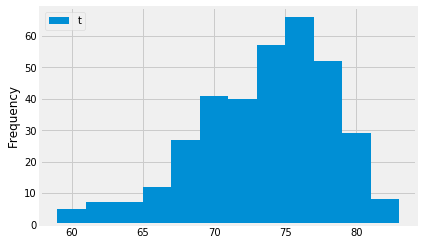

In [60]:
#plot annual data into a histogram; set bins = 12

nbins = 12

plt.hist(list_annual_data, bins=nbins)

plt.ylabel('Frequency')
plt.legend('tobs', loc='upper left')


plt.show()

In [27]:
#see app.py for flask code

prcp_dict = {i:x for i,x in combined_data}
